In [34]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from itertools import combinations
import igraph as ig
%config InlineBackend.figure_formats = ['svg']

### Load Data


In [35]:
con = sqlite3.connect("emps.db")

module = pd.read_sql_query("SELECT * FROM module", con)
module_discipline = pd.read_sql_query("SELECT * FROM module_discipline", con)
programme = pd.read_sql_query("SELECT * FROM programme", con)
requisite = pd.read_sql_query("SELECT * FROM requisite", con)
staff = pd.read_sql_query("SELECT * FROM staff", con)
stage_module = pd.read_sql_query("SELECT * FROM stage_module", con)

In [36]:
edge_sql = """
WITH filtered_modules AS (
	SELECT DISTINCT
		moduleCode
	FROM
		stage_module
	WHERE
		stage_module.moduleCode IS NOT NULL
		AND moduleTitle NOT LIKE '%elective%'
		AND moduleTitle NOT LIKE '%free choice%'
		AND stage_module.program_id IN(
			SELECT
				id FROM programme
			WHERE
				"year" BETWEEN 2021 AND 2024
				AND title LIKE '%mathematics%'
				AND programme. "type" = "Undergraduate")
)
SELECT
	*
FROM
	"requisite"
WHERE
	requisite. "module" IN filtered_modules
	AND requisite.requires IN filtered_modules;
"""
edge_df = pd.read_sql_query(edge_sql, con)
node_sql = """
SELECT DISTINCT
	MIN(sm.stage) AS stage,
	sm.moduleCode,
	sm.moduleTitle,
	sm.moduleCredits,
	m.credit,
	MIN(sm.isCompulsory) AS IsCompulsory,
	MAX(sm.isNonCondonable) AS IsNonCondonable,
	m.studentsCount,
	m.year
FROM
	stage_module AS sm
	LEFT JOIN "module" AS m ON sm.moduleCode = m.moduleCode
WHERE
	sm.moduleCode IS NOT NULL
	AND sm.moduleTitle NOT LIKE '%elective%'
	AND sm.moduleTitle NOT LIKE '%free choice%'
	AND sm.moduleCode NOT IN('xxxxxxx', 'BE*M**', 'BE*M***', 'BEE3*', 'BEE3***', 'BEE3****', 'BEE3XXX', 'BEM2***', 'BIOMXXX', 'MTH****', 'MTH2XXX/3XXX', 'MTH3***', 'PHYMXXX', 'GEOMXXX')
	AND sm.program_id IN(
		SELECT
			id FROM programme
		WHERE
			"year" BETWEEN 2021 AND 2024
			AND title LIKE '%mathematics%'
			AND programme. "type" = "Undergraduate")
GROUP BY
	sm.moduleCode;
"""
node_df = pd.read_sql_query(node_sql, con)

all_modules_nx = nx.DiGraph()

for index, row in node_df.iterrows():
    node_id = row["moduleCode"]
    attributes = {k: v for k, v in row.items() if k != "moduleCode"}
    all_modules_nx.add_node(node_id, **attributes)

for index, row in edge_df.iterrows():
    source = row["module"]
    target = row["requires"]
    attributes = {k: v for k, v in row.items() if k != "module" and k != "requires"}
    all_modules_nx.add_edge(source, target, **attributes)
    all_modules_nx.edges[source, target]["label"] = "requires"

### Subject Choice Data


Business Modules
BEE1038
BEM1006
BEM2007
BEM2036
BEM2031
BEM3060
BEM3052


In [37]:
J_y1 = ["ECM1400", "ECM1410", "ECM1413", "ECM1414", "MTH1001", "MTH1002"]
J_y2 = [
    "ECM2414",
    "ECM2418",
    "ECM2419",
    "ECM2423",
    "ECM2433",
    "ECM2434",
    "MTH2008",
    "MTH2011",
]
J_y3 = ["ECM3401", "ECM3408", "ECM3420", "ECM3423", "MTH3019", "MTH3022"]
J = all_modules_nx.subgraph(J_y1 + J_y2 + J_y3)

In [38]:
L_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
L_y2 = [
    "MTH2003",
    "MTH2004",
    "MTH2008",
    "MTH2009",
    "MTH2010",
    "MTH2011",
]  # NOTE: and sociology modules
L_y3 = [
    "MTH3004",
    "MTH3022",
    "MTH3019",
    "MTH3042",
    "MTH3035",
]  # NOTE: and sociology modules

L = all_modules_nx.subgraph(L_y1 + L_y2 + L_y3)

In [39]:
M_y1 = ["ECM1400", "ECM1410", "ECM1413", "ECM1414", "MTH1001", "MTH1002"]
M_y2 = [
    "ECM2414",
    "ECM2418",
    "MTH2010",
    "ECM2427",
    "ECM2433",
    "ECM2434",
    "MTH2008",
    "MTH2011",
]
M_y3 = ["ECM3420", "ECM3428", "MTH3004", "MTH3019", "ECM3408", "ECM3401"]

M = all_modules_nx.subgraph(M_y1 + M_y2 + M_y3)

In [40]:
BJ_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
BJ_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2006", "MTH2008", "MTH2009"]
BJ_y3 = [
    "BEM2031",
    "BEM2036",
    "MTH3024",
    "MTH3028",
    "MTH3030",
    "MTH3035",
    "MTH3042",
    "MTH3045",
]

BJ = all_modules_nx.subgraph(BJ_y1 + BJ_y2 + BJ_y3)

In [41]:
JLT_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
JLT_y2 = ["MTH2003", "MTH2006", "MTH2008", "MTH2010", "MTH2011", "BEE1038", "BEM2036"]
JLT_y3 = ["BEM2031", "MTH3019", "MTH3024", "MTH3028", "MTH3045"]

JT = all_modules_nx.subgraph(JLT_y1 + JLT_y2 + JLT_y3)

In [42]:
CC_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
CC_y2 = ["MTH2003", "MTH2006", "MTH2008", "MTH2010", "MTH2011", "BEE1038", "MTH2009"]
CC_y3 = [
    "MTH3028",
    "BEM2031",
    "MTH3004",
    "MTH3024",
    "MTH3038",
    "MTH3026",
    "MTH3022",
    "MTHM036",
]

CC = all_modules_nx.subgraph(CC_y1 + CC_y2 + CC_y3)

In [43]:
EP_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
EP_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2008", "MTH2009", "MTH2010"]
EP_y3 = [
    "MTH3019",
    "MTH3022",
    "MTH3035",
    "MTH3042",
    "MTH3007",
    "MTH3011",
]  # + German Beginners

EP = all_modules_nx.subgraph(EP_y1 + EP_y2 + EP_y3)

In [44]:
ZL_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
ZL_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2006", "MTH2008", "MTH2009"]
ZL_y3 = ["MTH3035", "MTH3006", "MTH3007", "MTH3042", "MTH3022", "BEM3060", "BEM3052"]

ZL = all_modules_nx.subgraph(ZL_y1 + ZL_y2 + ZL_y3)

In [45]:
IW_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
IW_y2 = ["MTH2003", "MTH2004", "MTH2005", "MTH2008", "MTH2009"]
IW_y3 = [
    "MTH3035",
    "MTH3006",
    "MTH3007",
    "MTH3042",
    "MTH3022",
    "MTH3011",
    "BEM3060",
    "BEM3052",
]

IW = all_modules_nx.subgraph(IW_y1 + IW_y2 + IW_y3)

In [46]:
K_y1 = ["MTH1001", "MTH1002", "MTH1003", "MTH1004"]
K_y2 = ["MTH2003", "MTH2006", "MTH2008", "MTH2009", "MTH2010", "MTH2011", "BEM1006"]
K_y3 = [
    "MTH3042",
    "MTH3022",
    "MTH3024",
    "MTH3035",
    "BEM2007",
    "BEM3060",
    "MTH3040",
    "MTH3028",
]

K = all_modules_nx.subgraph(K_y1 + K_y2 + K_y3)

### People Intersection & Combination


In [47]:
JL_intersecting_nodes = nx.intersection(J, L)
combined_JL_nx = nx.compose_all([J, L])
for node in combined_JL_nx.nodes:
    if node in JL_intersecting_nodes:
        combined_JL_nx.nodes[node]["color"] = "red"
    elif node in J:
        combined_JL_nx.nodes[node]["color"] = "green"
    elif node in L:
        combined_JL_nx.nodes[node]["color"] = "blue"
    else:
        combined_JL_nx.nodes[node]["color"] = "black"

In [48]:
people = [J, M, L, JT, EP, CC, K, ZL, IW, BJ]
people_names = ["J", "M", "L", "JT", "E", "C", "K", "Z", "I", "B"]

all_nx = nx.compose_all(people).copy()

for node in all_nx.nodes:
    score = 0
    for P in people:
        if node in P:
            score += 1
    all_nx.nodes[node]["count"] = score

### Comparison Functions


In [49]:
def overlap_coefficient(X, Y):
    intx = nx.intersection(X, Y)
    return len(intx.nodes) / min(len(X.nodes), len(Y.nodes))

In [50]:
def jaccard_index(X, Y):
    intersection = nx.intersection(X, Y)
    union = nx.compose(X, Y)
    return len(intersection) / len(union)

In [51]:
def node_symetric_difference(X, Y):
    intx = nx.intersection(X, Y)
    union = nx.compose(X, Y)
    return len(union.nodes - intx.nodes)

In [52]:
def compare_laplacian(X, Y):
    X_lap = nx.laplacian_spectrum(X.to_undirected())
    Y_lap = nx.laplacian_spectrum(Y.to_undirected())

    penalty = abs(len(X_lap) - len(Y_lap))
    longest = max(len(X_lap), len(Y_lap))

    X_lap = np.pad(X_lap, (0, longest - len(X_lap)))
    Y_lap = np.pad(Y_lap, (0, longest - len(Y_lap)))

    manhattan_distance = np.sum(np.abs(X_lap - Y_lap))

    return manhattan_distance + penalty

In [53]:
def compare_adjacency(X, Y):
    X_adj = nx.adjacency_spectrum(X.to_undirected())
    Y_adj = nx.adjacency_spectrum(Y.to_undirected())

    penalty = abs(len(X_adj) - len(Y_adj))
    longest = max(len(X_adj), len(Y_adj))

    X_adj = np.pad(X_adj, (0, longest - len(X_adj)))
    Y_adj = np.pad(Y_adj, (0, longest - len(Y_adj)))

    manhattan_distance = np.sum(np.abs(X_adj - Y_adj))

    return manhattan_distance + penalty

### Graph Comparisons


In [54]:
def compare_graph_similarity(graphs, functions):
    pairs = list(combinations(range(len(graphs)), 2))
    outputs = {}
    for func in functions:
        results = np.zeros((len(graphs), len(graphs)))
        for X, Y in pairs:
            results[X, Y] = results[Y, X] = func(graphs[X], graphs[Y])
        outputs[func.__name__] = results
    return outputs

In [55]:
comparison_functions = [
    overlap_coefficient,
    jaccard_index,
    node_symetric_difference,
    compare_laplacian,
    compare_adjacency,
]
similarities = compare_graph_similarity(people, comparison_functions)

for n, m in similarities.items():
    with np.printoptions(precision=3, suppress=True):
        print(f"{n} matrix:")
        # print(m)
        print(
            np.array2string(
                m,
                separator=" & ",
                max_line_width=np.inf,
                formatter={"int": lambda x: f"{x:d}"},
            )
        )

selected_measure = "node_symetric_difference"
distance_matrix = similarities[selected_measure]

name_mapping = {index: value for index, value in enumerate(people_names)}

distance_nx = nx.from_numpy_array(distance_matrix)
nx.relabel_nodes(distance_nx, name_mapping, False)

distances_nx = distance_nx.copy()
for u, v, data in distances_nx.edges(data=True):
    if "weight" in data:
        data["weight"] = round(data["weight"], 2)

overlap_coefficient matrix:
[[0.    & 0.8   & 0.4   & 0.385 & 0.312 & 0.294 & 0.294 & 0.267 & 0.267 & 0.188] &
 [0.8   & 0.    & 0.467 & 0.462 & 0.312 & 0.353 & 0.294 & 0.2   & 0.2   & 0.188] &
 [0.4   & 0.467 & 0.    & 0.692 & 0.867 & 0.733 & 0.8   & 0.733 & 0.733 & 0.667] &
 [0.385 & 0.462 & 0.692 & 0.    & 0.615 & 0.846 & 0.846 & 0.538 & 0.462 & 0.769] &
 [0.312 & 0.312 & 0.867 & 0.615 & 0.    & 0.562 & 0.688 & 0.867 & 0.933 & 0.688] &
 [0.294 & 0.353 & 0.733 & 0.846 & 0.562 & 0.    & 0.765 & 0.6   & 0.533 & 0.625] &
 [0.294 & 0.294 & 0.8   & 0.846 & 0.688 & 0.765 & 0.    & 0.733 & 0.667 & 0.75 ] &
 [0.267 & 0.2   & 0.733 & 0.538 & 0.867 & 0.6   & 0.733 & 0.    & 0.933 & 0.8  ] &
 [0.267 & 0.2   & 0.733 & 0.462 & 0.933 & 0.533 & 0.667 & 0.933 & 0.    & 0.733] &
 [0.188 & 0.188 & 0.667 & 0.769 & 0.688 & 0.625 & 0.75  & 0.8   & 0.733 & 0.   ]]
jaccard_index matrix:
[[0.    & 0.667 & 0.207 & 0.179 & 0.161 & 0.156 & 0.156 & 0.129 & 0.129 & 0.091] &
 [0.667 & 0.    & 0.25  & 0.222 & 0.16

### Clustering / Community Detection


In [56]:
clustering = DBSCAN(eps=8, min_samples=2, metric="precomputed")
# ['J', 'M', 'L', 'BJ', 'JLT', 'CC', 'K'  'ZL', 'EP','IW']
# [ CS, CS,   ?,  Ap/St, St,   P/St, P/St   Ap,  P/Ap,  P,  ]
clustering.fit(distance_matrix)
clustering.labels_

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
# ['J', 'M', 'L', 'BJ', 'JLT', 'CC', 'K'  'ZL', 'EP','IW']
# [ CS, CS,   ?,  Ap/St, St,   P/St, P/St   Ap,  P/Ap,  P,  ]

km = KMeans(n_clusters=3).fit(distance_matrix)
km.labels_

array([1, 1, 0, 2, 0, 2, 2, 0, 0, 0], dtype=int32)

In [58]:
comp = nx.community.girvan_newman(distances_nx)
tuple(sorted(c) for c in next(comp))

(['J'], ['B', 'C', 'E', 'I', 'JT', 'K', 'L', 'M', 'Z'])

In [59]:
nx.community.louvain_communities(distances_nx, resolution=1.1)

[{'B', 'C', 'I', 'L', 'M'}, {'E', 'J', 'JT', 'K', 'Z'}]

# Visualisations


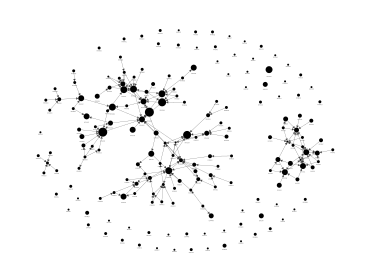

In [60]:
all_modules_ig = ig.Graph.from_networkx(all_modules_nx)

sizes = [v["studentsCount"] for v in all_modules_ig.vs]
normalized_sizes = np.interp(sizes, (np.nanmin(sizes), np.nanmax(sizes)), (3, 9))

for i, v in enumerate(all_modules_ig.vs):
    size = normalized_sizes[i]
    size = 2 if np.isnan(size) else size
    v["size"] = size

layout = all_modules_ig.layout_fruchterman_reingold(niter=1000)

fig, ax = plt.subplots()
pl = ig.plot(
    all_modules_ig,
    target=ax,
    layout=layout,
    margin=0,
    vertex_label=[v["_nx_name"] for v in all_modules_ig.vs],
    vertex_label_dist=2,
    vertex_label_size=0.5,
    vertex_color="black",
    edge_width=0.2,
    vertex_frame_width=0,
    bbox=(1200, 1200),
    edge_arrow_size=2,
    edge_arrow_width=2,
)
fig.savefig("all.svg", transparent=True)
plt.show()

In [61]:
def small_vis(
    G,
    target,
    vertex_color="black",
    layout="auto",
    margin=0,
    vertex_size=10,
    vertex_label=None,
    vertex_label_dist=2,
    vertex_label_size=7,
    edge_width=1.5,
    vertex_frame_width=0,
    edge_arrow_size=3,
    edge_arrow_width=3,
    **kwargs
):
    vertex_label = (
        [v["_nx_name"] for v in G.vs]
        if vertex_label is None
        else (
            [v[vertex_label] for v in G.vs]
            if isinstance(vertex_label, str)
            else vertex_label
        )
    )
    return ig.plot(
        G,
        target=target,
        vertex_color=vertex_color,
        layout=layout,
        margin=margin,
        vertex_size=vertex_size,
        vertex_label=vertex_label,
        vertex_label_dist=vertex_label_dist,
        vertex_label_size=vertex_label_size,
        edge_width=edge_width,
        vertex_frame_width=vertex_frame_width,
        edge_arrow_size=edge_arrow_size,
        edge_arrow_width=edge_arrow_width,
        **kwargs
    )

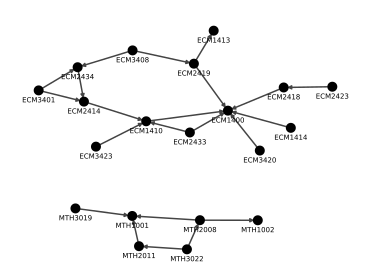

In [62]:
J_ig = ig.Graph.from_networkx(J)

fig, ax = plt.subplots()
pl = small_vis(J_ig, ax)
fig.savefig("J.svg", transparent=True)
plt.show()

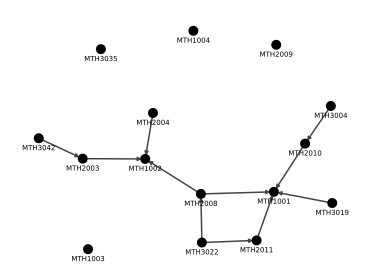

In [63]:
L_ig = ig.Graph.from_networkx(L)

fig, ax = plt.subplots()
pl = pl = small_vis(L_ig, ax)
fig.savefig("L.svg", transparent=True)
plt.show()

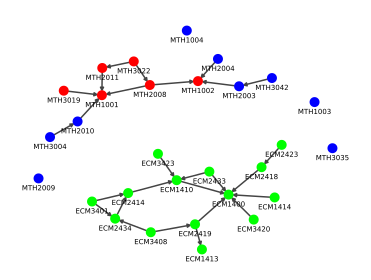

In [64]:
combined_JL_ig = ig.Graph.from_networkx(combined_JL_nx)

fig, ax = plt.subplots()
pl = pl = small_vis(combined_JL_ig, ax, vertex_color=None)
fig.savefig("2combined.svg", transparent=True)
plt.show()

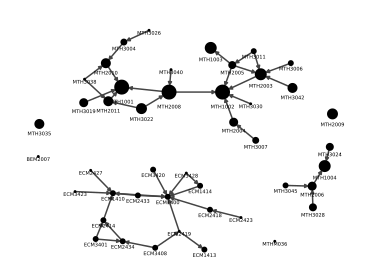

In [65]:
all_ig = ig.Graph.from_networkx(all_nx)
sizes = [v["count"] for v in all_ig.vs]
sizes = np.interp(sizes, (np.min(sizes), np.max(sizes)), (5, 15))
sizes = [s if s != 5 else 3 for s in sizes]
fig, ax = plt.subplots()
pl = pl = small_vis(all_ig, ax, vertex_size=sizes, vertex_label_size=5)
fig.savefig("10combined.svg", transparent=True)
plt.show()

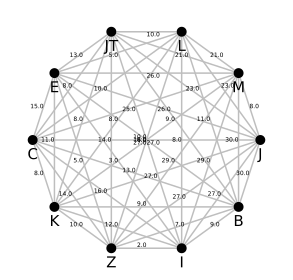

In [68]:
distances_ig = ig.Graph.from_networkx(distances_nx)

fig, ax = plt.subplots()
ax.set_aspect("equal")
pl = pl = small_vis(
    distances_ig,
    ax,
    layout="circle",
    edge_label=[x["weight"] for x in distances_ig.es],
    vertex_label_size=15,
    vertex_label_dist=3,
    edge_label_size=6,
    edge_color="gray",
    bbox=(1200, 1200),
)
fig.savefig(f"K_{selected_measure}.svg", transparent=True)
plt.show()

# Knowledge Representation Via Directed Graphs


## Network Representations of various Mathematics Degrees

- Graphs with degree dependencies
- Graphs with degree dependencies + MSC


Consider a directed graph $G$, whose vertices represent modules in the College of Engineering, Mathematics and Physical Sciences (EMPS) at Exeter University. In this graph, the directed edges represent a modules prerequisite. For example if a edge has its tail at "MTH1001" and its head at "MTH2010" it encodes the information that a student must take or have taken Mathematical Structures in order to take Groups, Rings and Fields. These edges will have the value "requires". Later we will add different types of edges to the graph, but we shall stick to just module requirements for now.


The EMPS modules which a mathematics student at Exeter University takes can therefore be represented as a subgraph of $G$, since this graph contains all modules, and module requirements are the same for every student. As part of our investigation we analysed 10 students Mathematics degrees, each taking a variety of different mathematics and non-mathematics modules. Each student was also asked to assign to each module a variety of Mathematical Subject Classification (MSC) codes [CITE]. MSC codes are used to categorise mathematical fields and can be used to represent the type of mathematical content a module covers. Each individual gave their own MSC codes for each module, as different students perception of each module may be different. The MSC module codes have been omitted in the following example for readability.


## Methods for Comparing Similarity

- The Overlap Coefficient, also known as the Szymkiewicz-Simpson coefficient
- Graph Edit Distance (Without MSC)


## Practical Applications

- Guide for new students picking modules
- Improved graduate job searching, e.g. matching similarity of grad cracker or linkedin job posts and degree graph (using LLMs)


## LLM Categorisation

- Problems with LLMs: ChatGPT hallucinates of MSC codes e.g.
  68N30 - Mathematical aspects of software engineering in general
  68N31 - Predesign
  68N32 - Design
- Problems with LLMs: Context length, needs to be able to provide enough tokens (words) to give the whole MSC and also EMPS module description, context length is $O(n^2)$
- Around 40k tokens for MSC code and title
- Around 4K tokens for Module Descriptors
- Solution use Claude, arguably best current model, largest context window and input token limit (200K). Do prompt engineering to avoid hallucinations

```
This is the MSC subject classifications is CSV format:
<MSC>
    {msc_text}
</MSC>

This is a universities module description
<module>
    {module_description}
</module>

Using the MSC subject classifications, classify this module. Only answer if you know the answer with certainty. Justify your answers. List the classification or classifications inside <classification> XML tags.
```


## Machine Learning Methods

- Use DBSCAN to cluster types of degrees based on distances between individuals
